In [ ]:
!nvidia-smi

Wed Apr  6 09:08:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cd drive/MyDrive/DL_Assignment2/data

/content/drive/.shortcut-targets-by-id/15bq-XlNJT4oXrmSycUNcRCO-SG71cV-g/data


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import time
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.image as mpimg
import torch.optim as optim
import matplotlib.patches as mpatches

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_path = '/content/drive/MyDrive/DL_Assignment2/'
base_path = os.getcwd()
parasite_path = os.getcwd() + str('/Parasitized/')
non_parasite_path = os.getcwd() + str('/Uninfected/')

# Visualization

Images with parasite


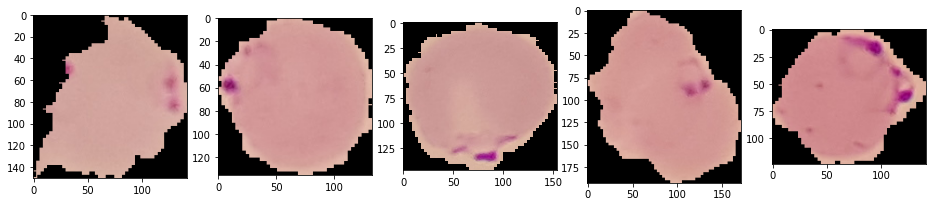

Images without parasite


<Figure size 432x288 with 0 Axes>

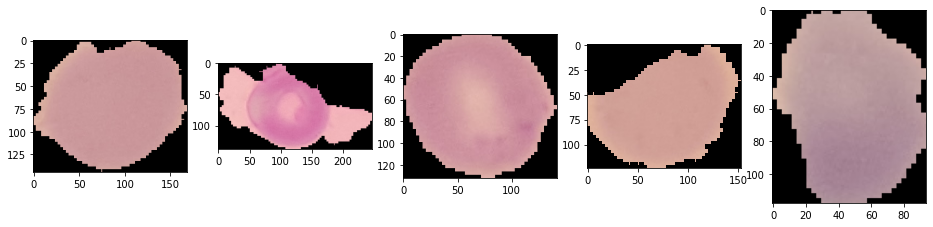

<Figure size 432x288 with 0 Axes>

In [ ]:
def visualise():
      print('Images with parasite')
      parasite_images = []
      non_parasite_images = []
      count = 0
      
      for name in os.listdir(parasite_path):
        if '.png' in name:
          count+=1
          parasite_images.append(Image.open(os.path.join(parasite_path, name)))
        
        if(count==5):
          break

      count = 0
      for name in os.listdir(non_parasite_path):
        if '.png' in name:
          non_parasite_images.append(Image.open(os.path.join(non_parasite_path, name)))
          count+=1

        if(count==5):
          break
      
      plt.figure(figsize = (16, 5))
      for i in range(5):
        curr = parasite_images[i]
        plt.subplot(1, 5, i+1)
        plt.imshow(curr)
      plt.show()
      plt.clf()

      plt.figure(figsize = (16, 5))
      print('Images without parasite')
      for i in range(5):
        curr = non_parasite_images[i]
        plt.subplot(1, 5, i+1)
        plt.imshow(curr)

      plt.show()
      plt.clf()

visualise()

# CNN Model

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, in_channels = 1, dropout = 0, dropout_type = 0, initialization_type = 0):
        super(MyCNN, self).__init__()
        self.dropout = dropout
        self.dropout_type = dropout_type
        self.initialization = initialization_type 
        self.conv1 = nn.Conv2d(
            in_channels = in_channels,
            out_channels = 8,
            kernel_size = (9, 9),
            stride = (2, 2),
            padding = (1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = (6, 6),
            stride = (2, 2),
            padding = (1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = (3, 3),
            stride = (2, 2),
            padding = (1, 1),
        )

        self.pool = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(800, 64)
        self.fc1 = nn.Linear(64, 1)
        self.initialize_weights()
        self.drop = nn.Dropout(p=self.dropout)

    def forward(self, x):
        ## 150 -> (150 - 9 + 2 ) / 2 + 1 = 73
        x = self.pool(self.conv1(x))

        if(self.dropout_type == 1):
          x = self.drop(x)
        
        x = self.conv2(x)

        if(self.dropout_type == 1):
          x = self.drop(x)
        
        x = self.conv3(x)

        if(self.dropout_type == 1):
          x = self.drop(x)
        
        x = x.view(-1, 800)
        x = self.fc(x)

        if(self.dropout_type == 2):
          x = self.drop(x)
        
        x = self.fc1(x)
        x = x.view(-1)
        return torch.sigmoid(x)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              if(self.initialization == 0):
                nn.init.zeros_(m.weight)
                
              elif(self.initialization == 1):
                nn.init.normal_(m.weight, mean=0, std=0.01)
              
              else:
                nn.init.kaiming_uniform_(m.weight)

    def compute_l1_loss(self, w):
      ans = 0
      for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              ans += torch.abs(m).sum()
      return ans
  
    def compute_l2_loss(self, w):
      ans = 0
      for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              ans += torch.square(m).sum()
      return ans

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, l1_reg = 0, l2_reg = 0):

  train_loss_vs_epoch = []
  val_loss_vs_epoch = []
  num_epochs = []
  for epoch in range(epochs):
      num_epochs.append(epoch+1)
      print("Epoch "+str(epoch+1))
      cur_loss = 0
      val_loss = 0
      for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
          data = data.to(device=device)
          target = target.to(device=device)
          target = target.float()
          optimizer.zero_grad()
          
          output = model(data)
          output = output.float()
          # print(output)
          loss = criterion(output, target)
          
          if(l1_reg):
            loss += model.compute_l1_loss()
          if(l2_reg):
            loss += model.compute_l2_loss()
          
          loss.backward()
          optimizer.step()
          cur_loss += loss.cpu().detach().numpy()

      for batch_idx, (data, target) in enumerate(tqdm(val_loader)):
          data = data.to(device=device)
          target = target.to(device=device)
          target = target.float()
          output = model(data)
          output = output.float()
          loss = criterion(output, target)

          val_loss += loss.cpu().detach().numpy()
        
      train_loss_vs_epoch.append(cur_loss/len(train_loader))
      val_loss_vs_epoch.append(val_loss/len(val_loader))

  return train_loss_vs_epoch, val_loss_vs_epoch, num_epochs

def test_model(model, test_loader):
  model.eval()
  accuracy = 0.0
  total = 0.0

  with torch.no_grad():
      for (data, target) in test_loader:
          data = data.to(device=device)
          target = target.to(device=device)
          optimizer.zero_grad()
          outputs = model(data)
          outputs[outputs>=0.5] = 1
          outputs[outputs<0.5] = 0

          total += target.size(0)
          accuracy += (outputs == target).sum().item()
  
  accuracy = (100 * accuracy / total)
  print("Accuracy is: " +str(accuracy))

def plot_loss(train_loss_vs_epoch, val_loss_vs_epoch, num_epochs):
  plt.figure(figsize=(12, 10))
  plt.plot(num_epochs,train_loss_vs_epoch, color='C0')
  plt.plot(num_epochs,val_loss_vs_epoch, color='C1')
  pop_a = mpatches.Patch(color='C0', label='Train loss')
  pop_b = mpatches.Patch(color='C1', label='Validation loss')
  plt.legend(handles=[pop_a,pop_b])
  plt.title("Loss per epoch")
  plt.xlabel("Epoch number")
  plt.ylabel("Loss")
  plt.show()


def process_all(model, criterion, optimizer, train_loader, val_loader, test_loader, l1_reg = 0, l2_reg = 0):
    train_loss_vs_epoch, val_loss_vs_epoch, num_epochs = train_model(model, criterion, optimizer, train_loader, val_loader)
    plot_loss(train_loss_vs_epoch, val_loss_vs_epoch, num_epochs)
    test_model(model, test_loader)

def load_saved_model(model_name, device, model):
    model_name = model_path + model_name
    model.load_state_dict(torch.load(model_name))
    model = model.to(device)
    model.eval()
    return model

In [ ]:
composed_transforms = transforms.Compose([transforms.Resize(size=(100, 100)),transforms.ToTensor(),transforms.Normalize((0,0,0),(255,255,255))])
dataset = ImageFolder(root=base_path,transform=composed_transforms)

total_samples = len(dataset)
val_samples = len(dataset)//10
test_samples = len(dataset)//10
train_samples = total_samples - val_samples - test_samples

In [ ]:
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_samples, test_samples, val_samples])
batch_size = 1024
epochs = 10
learning_rate = 1e-3

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

# Different type of initialization

Epoch 1


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Epoch 2


100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


Epoch 3


100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


Epoch 4


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 6


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 7


100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


Epoch 8


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Epoch 9


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 10


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


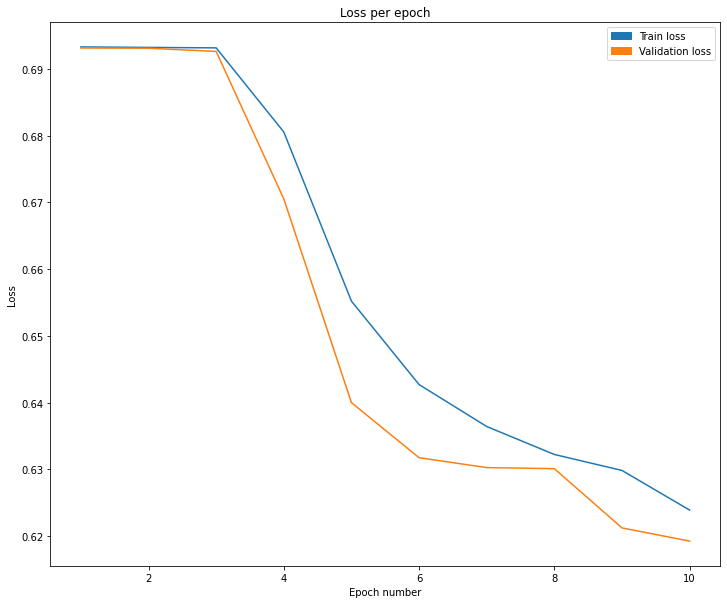

Accuracy is: 65.66243194192377


In [ ]:
model = MyCNN(in_channels = 3, initialization_type = 0).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader)
torch.save(model.state_dict(), model_path + 'zero_init' + '.pkl')

Epoch 1


100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


Epoch 2


100%|██████████| 3/3 [00:09<00:00,  3.13s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 5


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 6


100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


Epoch 7


100%|██████████| 3/3 [00:09<00:00,  3.13s/it]


Epoch 8


100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


Epoch 9


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


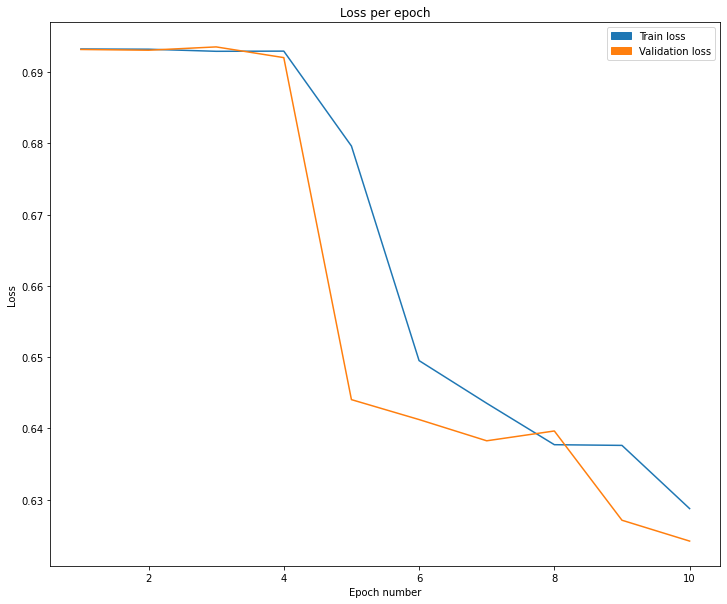

Accuracy is: 65.19056261343013


In [ ]:
model = MyCNN(in_channels = 3, initialization_type = 1).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader)
torch.save(model.state_dict(), model_path + 'random_init' + '.pkl')

Epoch 1


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 2


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 8


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Epoch 9


100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


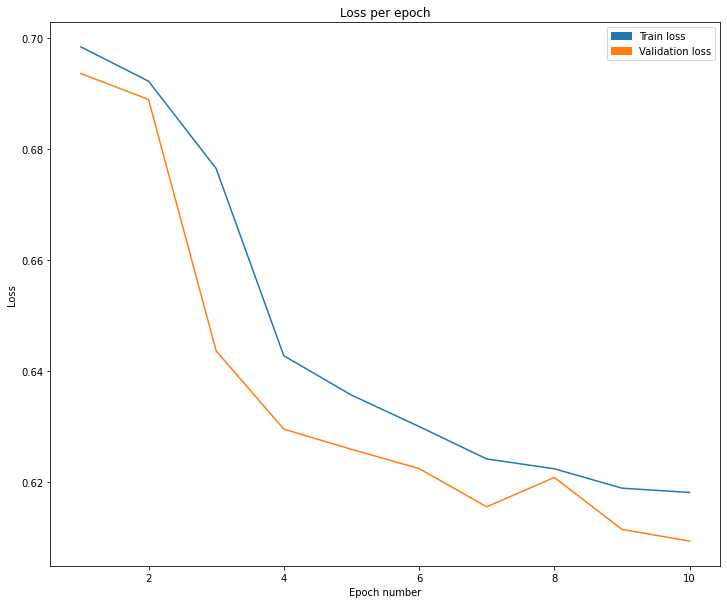

Accuracy is: 67.33212341197822


In [ ]:
model = MyCNN(in_channels = 3, initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader)
torch.save(model.state_dict(), model_path + 'he_init' + '.pkl')

Clearly we can see He initilization outperforms random and zero initialization
This is because He initialization dominates in case of ReLu activation functions (experimentally obtained)
It is similar to Xavier but has a multiple of 2 extra, hence no vanishing or exploding gradient problems

# Types of Dropout

Epoch 1


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 2


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Epoch 8


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Epoch 9


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


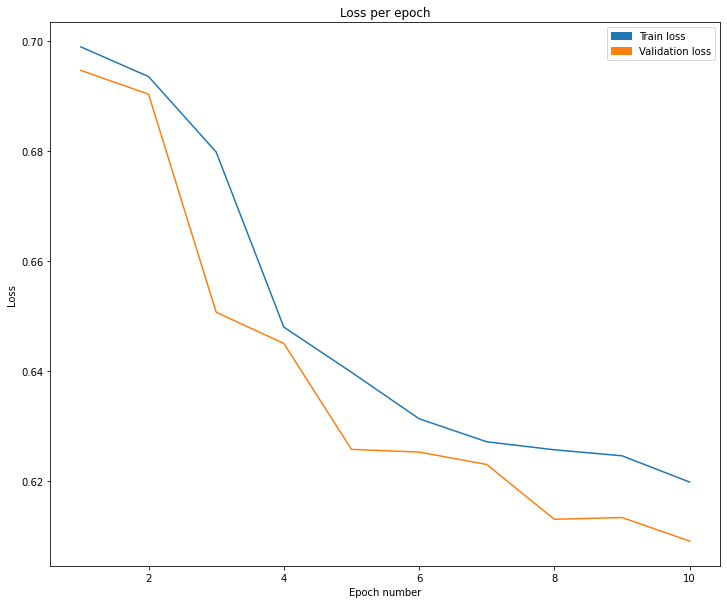

Accuracy is: 67.36842105263158


In [ ]:
model = MyCNN(in_channels = 3, dropout = 0.25, dropout_type = 1,initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader)
torch.save(model.state_dict(), model_path + 'he_init_drop_1' + '.pkl')

Epoch 1


100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


Epoch 2


100%|██████████| 3/3 [00:08<00:00,  2.82s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Epoch 8


100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


Epoch 9


100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


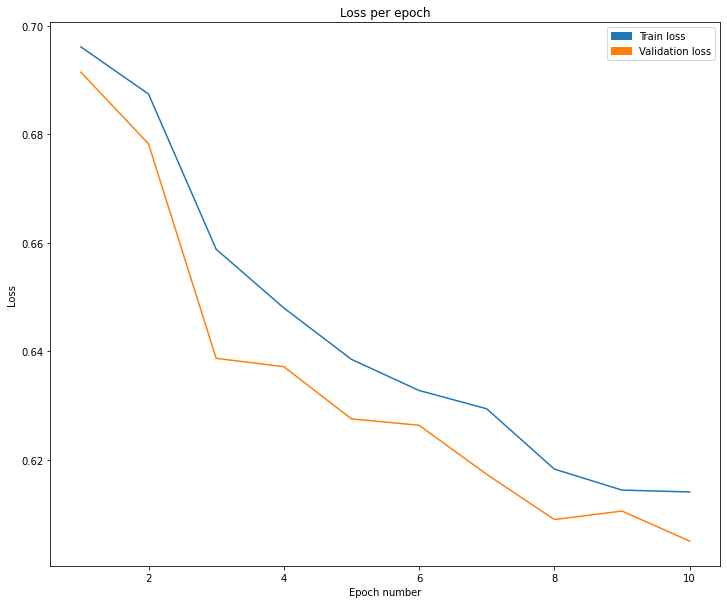

Accuracy is: 66.17059891107078


In [ ]:
model = MyCNN(in_channels = 3, dropout = 0.25, dropout_type = 2,initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader)
torch.save(model.state_dict(), model_path + 'he_init_drop_2' + '.pkl')

Dropout between convolutional layers is better as it tries to hide the features obtained initially and hence the model benefits for regularization aspect

# L1 and L2 regularization

Epoch 1


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Epoch 2


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Epoch 3


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Epoch 4


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 7


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Epoch 8


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Epoch 9


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 10


100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


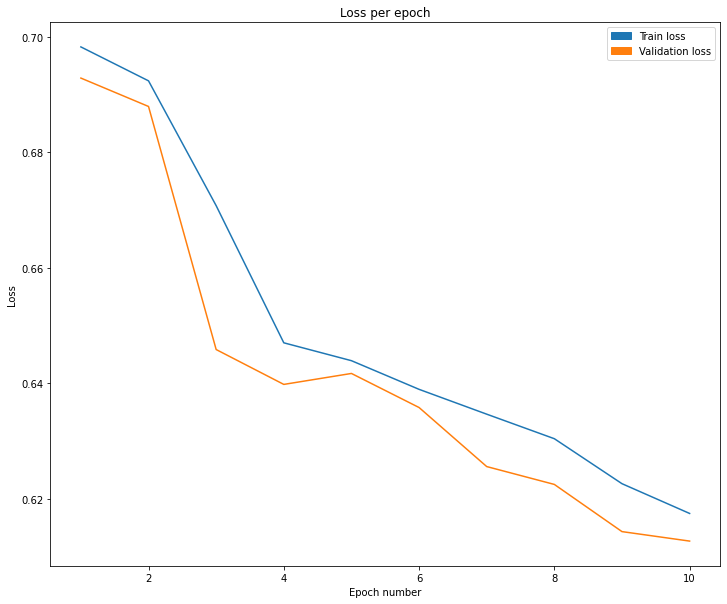

Accuracy is: 66.53357531760436


In [ ]:
model = MyCNN(in_channels = 3, dropout = 0.25, dropout_type = 1,initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader, l1_reg = 1)
torch.save(model.state_dict(), model_path + 'he_init_drop_2_l1_reg' + '.pkl')

Epoch 1


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 2


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 5


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Epoch 8


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Epoch 9


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


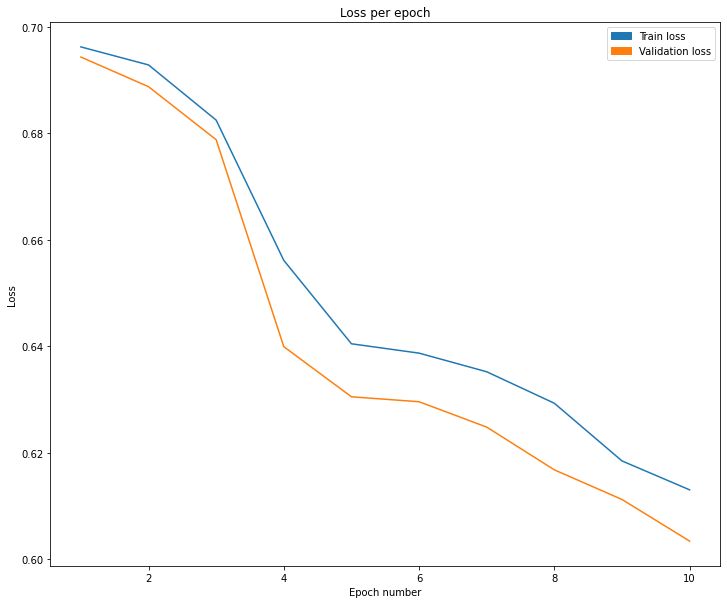

Accuracy is: 67.1869328493648


In [ ]:
model = MyCNN(in_channels = 3, dropout = 0.25, dropout_type = 1,initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader, l2_reg = 1)
torch.save(model.state_dict(), model_path + 'he_init_drop_2_l1_reg' + '.pkl')

Epoch 1


100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


Epoch 2


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


Epoch 3


100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


Epoch 4


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 5


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Epoch 6


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 7


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 8


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Epoch 9


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 10


100%|██████████| 3/3 [00:08<00:00,  3.00s/it]


Epoch 11


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 12


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 13


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Epoch 14


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


Epoch 15


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 16


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 17


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 18


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 19


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 20


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


Epoch 21


100%|██████████| 3/3 [00:08<00:00,  3.00s/it]


Epoch 22


100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


Epoch 23


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 24


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


Epoch 25


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Epoch 26


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 27


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


Epoch 28


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 29


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Epoch 30


100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


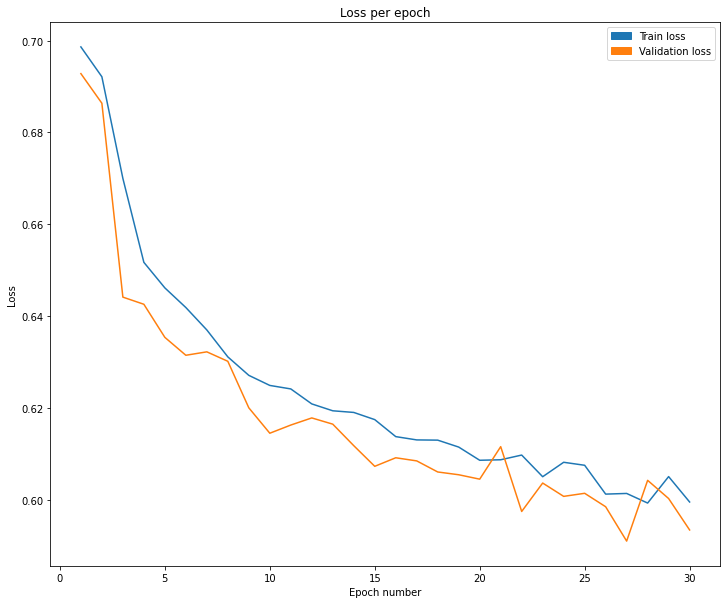

Accuracy is: 69.07441016333938


In [ ]:
epochs = 30
model = MyCNN(in_channels = 3, dropout = 0.25, dropout_type = 1,initialization_type = 2).to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
process_all(model, criterion, optimizer, train_loader, val_loader, test_loader, l2_reg = 1)
torch.save(model.state_dict(), model_path + 'best_model_dropout_l2_reg_he_init' + '.pkl')

L2 regularization outpeforms L1 because L1 reg. makes the weight go the exactly 0 and hence may lead to necessary features being discarded